In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation

'''几点说明 
1. transforms.RandomResizedCrop： 
   A crop of random size (default: of 0.08 to 1.0) of the original size 
   and a random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. 
   This crop is finally resized to given size. 
2. 变成了tensor之后再归一化，两个列表分别给出了三个通道上的均值和标准差'''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'ABC'
'''torchvision.datasets.ImageFolder()适用于不同类别的图片保存在不同文件夹下的情况，返回的是一个迭代器对象
第一个参数是这些图片（保存在不同文件夹下）的根目录
第二个参数是要对这些图片做的变换，属于torchvision.transforms
'''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
'''除了用上面这种方法获得“数据集对象”之外，
   还可以使用torch.utils.data.DataSet方法（这种方法适合于所有图片在一个文件夹下）'''
'''多线程读取数据集,'''
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
'''返回训练集的图片数量和验证集的图像数量'''
print(dataset_sizes['train'])
print(dataset_sizes['val'])
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1049
116
cuda:0


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



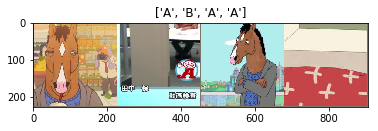

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    '''将数组的值都限制在0到1，小的值变成0，大的值变成1'''
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
'''得到的结果inputs已经是tensor了'''
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            '''开始使用dataloaders来遍历数据集，
            每次都是得到一批tensor和其对应的标签'''
            for inputs, labels in dataloaders[phase]:
                '''要把数据(转化好的tensor)和标签都一并送到GPU上'''
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            '''每个epoch结束之后，打印一下这一个epoch里的平均loss和平均准确率'''
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    '''把效果最好的model的状态字典加载给model并返回
    用到了.state_dict()和.load_state_dict（状态字典）两种方法'''
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    '''就是一些可视化的操作，不是这次最重要的内容，先跳过去'''
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [6]:
model_ft = models.resnet18(pretrained=True)
'''resnet只有1个全连接层。这里取出它的.fc.in_features属性'''
num_ftrs = model_ft.fc.in_features
'''将这个全连接层的尺寸修改一下（换一个新的上去:) ）'''
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
'''torch.optim.lr_scheduler 学习率调度器 
可以指定每隔多少个epoch，让学习率变为原来的多少'''
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
'''刚刚把模型（resnet18）送上去的时候，大约占了600MB，后来跑起来的时候占了933MB'''

Epoch 0/24
----------
train Loss: 0.7540 Acc: 0.6797
val Loss: 0.1668 Acc: 0.9397

Epoch 1/24
----------
train Loss: 0.5878 Acc: 0.7865
val Loss: 0.2125 Acc: 0.9397

Epoch 2/24
----------
train Loss: 0.4897 Acc: 0.8208
val Loss: 0.1296 Acc: 0.9483

Epoch 3/24
----------
train Loss: 0.5480 Acc: 0.8036
val Loss: 0.6215 Acc: 0.8103

Epoch 4/24
----------
train Loss: 0.4618 Acc: 0.8522
val Loss: 0.1037 Acc: 0.9828

Epoch 5/24
----------
train Loss: 0.4654 Acc: 0.8389
val Loss: 0.1551 Acc: 0.9569

Epoch 6/24
----------
train Loss: 0.5309 Acc: 0.8246
val Loss: 0.2285 Acc: 0.9138

Epoch 7/24
----------
train Loss: 0.3240 Acc: 0.8951
val Loss: 0.0585 Acc: 0.9828

Epoch 8/24
----------
train Loss: 0.2833 Acc: 0.9113
val Loss: 0.0379 Acc: 0.9828

Epoch 9/24
----------
train Loss: 0.2677 Acc: 0.9199
val Loss: 0.0494 Acc: 0.9828

Epoch 10/24
----------
train Loss: 0.2110 Acc: 0.9295
val Loss: 0.0477 Acc: 0.9828

Epoch 11/24
----------
train Loss: 0.2204 Acc: 0.9228
val Loss: 0.0386 Acc: 0.9914

Ep

'刚刚把模型（resnet18）送上去的时候，大约占了600MB，后来跑起来的时候占了933MB'

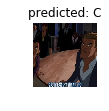

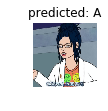

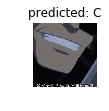

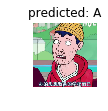

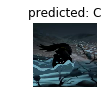

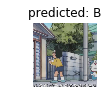

In [10]:
visualize_model(model_ft)

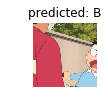

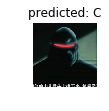

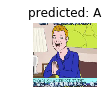

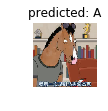

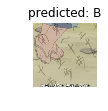

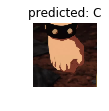

In [7]:
'''通过这种办法，下一次就可以不用从头开始训练了！'''
# torch.save(model_ft,'model.pth')
model_recover = torch.load('model.pth')
visualize_model(model_recover)

In [18]:
import os.path
from PIL import Image
data_dir = './ABC/'
file = sorted(os.listdir(data_dir + 'test/'))
ans = ''
for i in range(540):
#     print(i)
    image = Image.open(data_dir + 'test/' + str(i)+'.jpg')
    image = data_transforms['test'](image)
    image = image.to(device)
    output = model_recover(image.unsqueeze(0))
    _, predict = torch.max(output, dim=1)
    if predict == 0:
        ans += 'A'
    elif predict == 1:
        ans += 'B'
    else:
        ans += 'C'
print(ans)

ACCACABBBBBAACCACBACCABACCCAACBCBACBAAACCCCAACCBAABBCAAABACCACCACBBCBACACAAAABBBBAAAAABBCCBAACCBBBCBCBCAABBBBCBCABBBCACCAACCBCCCCBABBCACBBABABBCACAAABBCCCCBAACACBAACCCABABABABABCBBAAAACBBCBCAACBBBBBBBBBBACABCACBAAAACBBCAAABBAAAAAABCACBCBAABACBBCABCAACACABBCBACCBBABBCCACBABCABAACABBAAACBAACCAAAAAACBACCCABCBACCBCACCBACCBABCABCBCBCBCBABBBABABBCABBBCAABAACBABCACBBCCCCCCCACCBCCCBBABBAACBBACACCBABACBACCCBBCBACBACBAAACBBACAABBCBBCBACCCACACBBBBACABCCCACAACCABCBAAABABCBABAAABBCABCCCACBAABBBACBCBCBCCACABBBACBCCBCCCCACCCABBBAACBBBACCCACCAABBCBBA
